In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from utils import lat_lng2dist_ang, raster_evidence_geomap
from cmdstanpy import CmdStanModel, set_cmdstan_path
import os
import arviz as az

GEOLOCATION="unil"

GT_POINTS_CSV = f'datasets/raw/{GEOLOCATION}/gt_points.csv'
MEASUREMENTS_CSV = f'datasets/raw/{GEOLOCATION}/measurements.csv'
CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
STAN_MODEL_PATH = 'newmodel.stan'

measurements_df = pd.read_csv(MEASUREMENTS_CSV)
gt_points_df = pd.read_csv(GT_POINTS_CSV)
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
measurements_df["plot_label"] = measurements_df["measured_from"] + " (measured)"

/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='lng', ylabel='lat'>

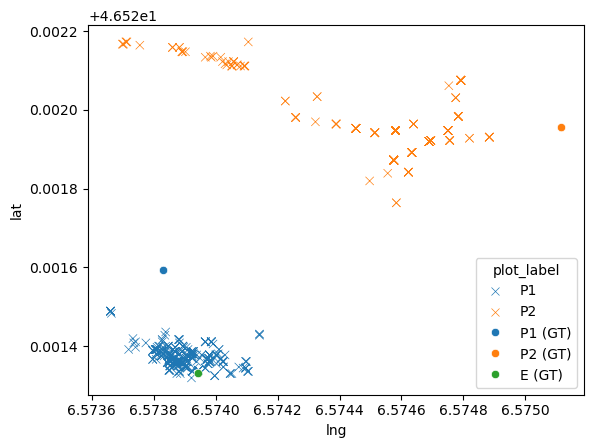

In [2]:
# visualize

fig, ax = plt.subplots()
sns.scatterplot(data=measurements_df, x='lng', y='lat', hue='measured_from', ax=ax, marker='x')
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
sns.scatterplot(data=gt_points_df, x='lng', y='lat', hue='plot_label', ax=ax)

In [3]:
gt_points_df

,name,lat,lng,plot_label
0,P1,46.521592,6.573832,P1 (GT)
1,P2,46.521955,6.575116,P2 (GT)
2,E,46.521331,6.573944,E (GT)


In [4]:
measurements_df

,measured_from,datetime,lat,lng,precise,plot_label
0,P1,2022-06-22 09:53:19,46.521344,6.573931,on,P1 (measured)
1,P1,2022-06-22 09:56:35,46.521408,6.573775,on,P1 (measured)
2,P1,2022-06-22 09:57:36,46.521381,6.573844,on,P1 (measured)
3,P1,2022-06-22 09:58:06,46.521361,6.573889,on,P1 (measured)
4,P1,2022-06-22 09:59:38,46.521386,6.573825,on,P1 (measured)
...,...,...,...,...,...,...
694,P2,2022-06-22 16:42:13,46.521931,6.574883,on,P2 (measured)
695,P2,2022-06-22 16:43:46,46.521931,6.574883,on,P2 (measured)
696,P2,2022-06-22 16:45:05,46.521931,6.574883,on,P2 (measured)
697,P2,2022-06-22 16:46:13,46.521931,6.574883,on,P2 (measured)


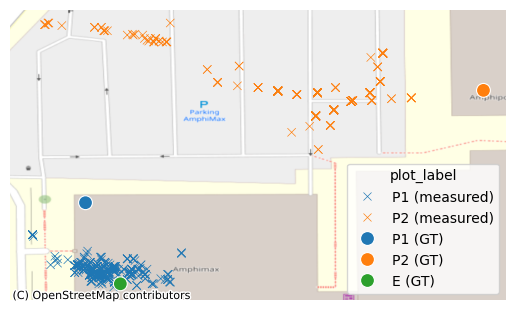

In [5]:
ax = raster_evidence_geomap(gt_points_df, measurements_df)

In [6]:
def prepare_measurements_for_proposal(ref_csv, proposal_name, known_points_df):
    proposal_lat_lng = known_points_df[known_points_df['name'] == proposal_name][['lat', 'lng']].values[0].tolist()
    print(f"Proposal {proposal_name} lat, lng: {proposal_lat_lng}")
    df = pd.read_csv(ref_csv)
    needed_columns = ['datetime', 'measured_from', 'lat', 'lng', 'precise']
    df = df[needed_columns]
    df = df[df['measured_from'] == proposal_name]
    df = df[df['precise'] == 'on']
    df = df.drop(columns=['precise'])
    df = df.sort_values(by='datetime', ascending=True, ignore_index=True)
    # flag indicating if two consecutive (by datetime) measurements  are the same (lat, lng)
    df['same_as_prev'] = df[['lat', 'lng']].duplicated(keep='first')
    num_rows = df.shape[0]
    num_duplicates = df['same_as_prev'].sum()
    print(f"Number of measurements for proposal {proposal_name}: {num_rows}")
    print(f"Number of duplicate consecutive measurements: {num_duplicates} ({num_duplicates/num_rows*100:.2f}%)")
    # remove duplicate consecutive measurements
    df = df[df['same_as_prev'] == False]
    df = df.drop(columns=['same_as_prev'])
    df = df.reset_index(drop=True)
    
    df["dist"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[0], axis=1)
    df["angle"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[1], axis=1)
    df["angle_deg"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[2], axis=1)

    print(f"Clean measurements for proposal {proposal_name}: {df.shape[0]}")
    display(df)
    display(df.describe())
    return df


def transform(measurements_df, gt_points_df):
    pass

P1_lat, P1_lng = gt_points_df[gt_points_df['name'] == 'P1'][['lat', 'lng']].values[0].tolist()
P2_lat, P2_lng = gt_points_df[gt_points_df['name'] == 'P2'][['lat', 'lng']].values[0].tolist()
E_lat, E_lng = gt_points_df[gt_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist()

print(f"P1: {P1_lat}, {P1_lng}")
print(f"P2: {P2_lat}, {P2_lng}")
print(f"E: {E_lat}, {E_lng}")
print(f"E using P1 as the center: {lat_lng2dist_ang([P1_lat, P1_lng], [E_lat, E_lng])}")
print(f"E using P2 as the center: {lat_lng2dist_ang([P2_lat, P2_lng], [E_lat, E_lng])}")

P1: 46.521592273, 6.573832039
P2: 46.521954786, 6.575116326
E: 46.521330555, 6.573944444
E using P1 as the center: (30.344572744546294, 2.8533795973322875, 163.48660827587835)
E using P2 as the center: (113.5817863518005, 4.055162326777971, -127.65631343517148)
